## Inputs and outputs are normalized

Readers can save the normalization configuration during training and use it when calling the model; this step is not shown here.

In [1]:
import deepxde as dde
import numpy as np
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

from deepxde.nn.pytorch.mionet import MIONetCartesianProd_4I
from deepxde.data.quadruple import QuadrupleCartesianProd_4I3O
from deepxde.data.quadruple import QuadrupleCartesianProd_MIMO
from deepxde.nn.pytorch.deeponet import DeepONetCartesianProd##########可以多输入多输出
import matplotlib.pyplot as plt
from deepxde.model import LossHistory
# 定义模型保存路径
model_save_path = "./models1008/checkpoints/"

# 如果目录不存在，创建它
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)


import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


2.3.1+cu118
True
1


In [ ]:
training_data = np.load("../data/" + "Train_3000.npz", allow_pickle=True)

testing_data = np.load("../data/"+ "Test_500.npz", allow_pickle=True)
xt1 = np.load("../data/"+ "xt.npz", allow_pickle=True)

In [3]:
train_sensor_values1 = training_data['sensor_values1']  
train_sensor_values2 = training_data['sensor_values2']  
train_sensor_values3 = training_data['sensor_values3']  
train_xt = xt1['xt']
train_Ts =  training_data ['Ts']
train_fps =  training_data ['fps']
train_lts =  training_data ['ltss']

train_mu1s =  training_data ['mu1s']
train_mu2s =  training_data ['mu2s']
train_alphas =  training_data ['alphas']


#result_multiple = torch.cat((tensor1, tensor3), dim=0)

test_sensor_values1 = testing_data['sensor_values1']  
test_sensor_values2 = testing_data['sensor_values2']  
test_sensor_values3 = testing_data['sensor_values3']  
test_xt = xt1['xt']  
test_Ts =  testing_data ['Ts']
test_fps =  testing_data ['fps']
test_lts =  testing_data ['ltss']

test_mu1s =  testing_data ['mu1s']
test_mu2s =  testing_data ['mu2s']
test_alphas =  testing_data ['alphas']


print(type(test_mu1s))

print("train_sensor_values1",train_sensor_values1.shape) 
print("train_sensor_values2",train_sensor_values2.shape) 
print("train_sensor_values3",train_sensor_values3.shape) 
print("train_xt",train_xt.shape)





<class 'numpy.ndarray'>
train_sensor_values1 (3000, 200)
train_sensor_values2 (3000, 200)
train_sensor_values3 (3000, 200)
train_xt (40000, 2)


In [5]:
train_sensor_values1 = train_sensor_values1.astype(np.float32) 
train_sensor_values2 = train_sensor_values2.astype(np.float32) 
train_sensor_values3 = train_sensor_values3.astype(np.float32) 
train_xt=train_xt.astype(np.float32) 
train_Ts =  train_Ts.astype(np.float32) 
train_fps =  train_fps.astype(np.float32) 
train_lts =  train_lts.astype(np.float32) 


train_mu1s =  train_mu1s.astype(np.float32) 
train_mu2s =  train_mu2s.astype(np.float32) 
train_alphas =  train_alphas.astype(np.float32) 

test_sensor_values1 = test_sensor_values1.astype(np.float32) 
test_sensor_values2 = test_sensor_values2.astype(np.float32)
test_sensor_values3 = test_sensor_values3.astype(np.float32)
test_xt=test_xt.astype(np.float32) 
test_Ts =  test_Ts.astype(np.float32) 
test_fps =  test_fps.astype(np.float32) 
test_lts =  test_lts.astype(np.float32) 

test_mu1s =  test_mu1s.astype(np.float32) 
test_mu2s =  test_mu2s.astype(np.float32) 
test_alphas =  test_alphas.astype(np.float32) 



In [6]:
def normalize_global(data, feature_range=(0, 1)):
    """
    对整个数组进行全局归一化，将所有数据缩放到指定范围。

    参数:
        data (numpy.ndarray): 输入数据，形状为 (n_samples, n_features)。
        feature_range (tuple): 目标范围 (min, max)，默认为 (0, 1)。

    返回:
        normalized_data (numpy.ndarray): 归一化后的数据。
        global_min (float): 数据的全局最小值，用于反归一化。
        global_max (float): 数据的全局最大值，用于反归一化。
    """
    min_val, max_val = feature_range
    global_min = np.min(data)
    global_max = np.max(data)
    
    # 防止除以零
    scale = global_max - global_min
    if scale == 0:
        scale = 1
    
    normalized_data = (data - global_min) / scale
    normalized_data = normalized_data * (max_val - min_val) + min_val
    
    return normalized_data, global_min, global_max

def inverse_normalize_global(normalized_data, global_min, global_max, feature_range=(0, 1)):
    """
    对全局归一化后的数据进行反归一化，还原到原始范围。

    参数:
        normalized_data (numpy.ndarray): 归一化后的数据。
        global_min (float): 数据的全局最小值，用于反归一化。
        global_max (float): 数据的全局最大值，用于反归一化。
        feature_range (tuple): 原归一化的范围 (min, max)，默认为 (0, 1)。

    返回:
        original_data (numpy.ndarray): 还原后的原始数据。
    """
    min_val, max_val = feature_range
    
    scale = global_max - global_min
    if scale == 0:
        scale = 1
    
    original_data = (normalized_data - min_val) / (max_val - min_val)
    original_data = original_data * scale + global_min
    
    return original_data

In [7]:
train_sensor_values1_scale,Nt_min,Nt_max=normalize_global(train_sensor_values1)
test_sensor_values1_scale=(test_sensor_values1 - Nt_min) / (Nt_max - Nt_min)
# normalized_test_data = normalized_test_data * (1 - 0) + 0  # 这里 feature_range 是 (0, 1)

train_sensor_values2_scale,Fin_min,Fin_max=normalize_global(train_sensor_values2)
test_sensor_values2_scale=(test_sensor_values2 - Fin_min) / (Fin_max - Fin_min)

train_sensor_values3_scale,Tb_min,Tb_max=normalize_global(train_sensor_values3)
test_sensor_values3_scale=(test_sensor_values3 - Tb_min) / (Tb_max - Tb_min)

print("train_sensor_values1_scale",train_sensor_values1_scale)
print("Nt_min",Nt_min)
print("Nt_max",Nt_max)
print("train_sensor_values2_scale",train_sensor_values2_scale)
print("Fin_min",Fin_min)
print("Fin_max",Fin_max)
print("train_sensor_values3_scale",train_sensor_values3_scale)
print("Tb_min",Tb_min)
print("Tb_max",Tb_max)

train_mu1s_scale,mu1_min,mu1_max =  normalize_global(train_mu1s[:,0])
test_mu1s_scale = (test_mu1s[:,0] - mu1_min) / (mu1_max - mu1_min)
train_mu2s_scale,mu2s_min,mu2s_max  =  normalize_global(train_mu2s[:,0])
test_mu2s_scale = (test_mu2s[:,0] - mu2s_min) / (mu2s_max - mu2s_min)
train_alphas_scale,alphas_min,alphas_max =  normalize_global(train_alphas[:,0])
test_alphas_scale = (test_alphas[:,0] - alphas_min) / (alphas_max - alphas_min)



print("train_mu1s",train_sensor_values3_scale)
print("mu1_min",mu1_min)
print("mu1_max",mu1_max)

print("train_mu2s_scale",train_mu2s_scale)
print("mu2s_min",mu2s_min)
print("mu2s_max",mu2s_max)

print("train_alphas_scale",train_alphas_scale)
print("alphas_min",alphas_min)
print("alphas_max",alphas_max)


train_Ts_scale,Ts_min,Ts_max =  normalize_global(train_Ts)
train_fps_scale,fps_min,fps_max =  normalize_global(train_fps)
train_lts_scale,lts_min,lts_max =  normalize_global(train_lts)

test_Ts_scale = (test_Ts - Ts_min) / (Ts_max - Ts_min)
test_fps_scale =  (test_fps - fps_min) / (fps_max - fps_min)
test_lts_scale =  (test_lts - lts_min) / (lts_max - lts_min)





#test_mu1s =  normalize_global(test_mu1s[:,0])
#test_mu2s =  test_mu2s[:,0]*scale_mu2
#test_alphas =  test_alphas[:,0]/scale_alpha




train_sensor_values1_scale [[0.00000000e+00 3.89827490e-02 7.77366161e-02 ... 6.49281561e-01
  6.37019873e-01 6.24668360e-01]
 [2.44281605e-01 2.41727039e-01 2.38972351e-01 ... 9.72284317e-01
  9.81639206e-01 9.90866840e-01]
 [1.00000000e+00 9.90159214e-01 9.80100632e-01 ... 9.08552825e-01
  9.10603523e-01 9.12312508e-01]
 ...
 [9.55685139e-01 9.61528957e-01 9.67105389e-01 ... 8.96626711e-02
  9.90412235e-02 1.08828306e-01]
 [6.88196898e-01 6.92890823e-01 6.97350502e-01 ... 1.20214617e-03
  7.91668892e-04 3.91880661e-04]
 [7.83890486e-01 7.87076652e-01 7.90244281e-01 ... 1.48242950e-01
  1.60083219e-01 1.72323629e-01]]
Nt_min 3.0
Nt_max 9.0
train_sensor_values2_scale [[1.00000000e+00 9.95508909e-01 9.91095781e-01 ... 7.60145544e-04
  3.08640330e-04 7.40960313e-05]
 [1.06986657e-01 1.10365123e-01 1.13561496e-01 ... 9.96090055e-01
  9.97538745e-01 9.98828292e-01]
 [8.33210826e-01 8.10916305e-01 7.88551450e-01 ... 7.80746400e-01
  7.65040994e-01 7.49078155e-01]
 ...
 [3.94555986e-01 3.920

In [8]:

# 将 numpy 数组转换为 torch 张量
train_mu1s_tensor = torch.tensor(train_mu1s_scale)
train_mu2s_tensor = torch.tensor(train_mu2s_scale)
train_alphas_tensor = torch.tensor(train_alphas_scale)
test_mu1s_tensor = torch.tensor(test_mu1s_scale)
test_mu2s_tensor = torch.tensor(test_mu2s_scale)
test_alphas_tensor = torch.tensor(test_alphas_scale)

train_params = torch.stack((train_mu1s_tensor, train_mu2s_tensor, train_alphas_tensor), dim=1)
test_params = torch.stack((test_mu1s_tensor, test_mu2s_tensor, test_alphas_tensor), dim=1)


In [10]:

#####组合输出数据
# 将 NumPy 数组转换为 PyTorch 张量
train_Ts = torch.from_numpy(train_Ts_scale)
train_fps = torch.from_numpy(train_fps_scale)
train_lts = torch.from_numpy(train_lts_scale)

y_train=torch.cat((train_Ts, train_fps), dim=0)
y_train=torch.cat((y_train, train_lts), dim=0)
y_train=y_train.numpy()

#result_multiple = torch.cat((tensor1, tensor3), dim=0)


test_Ts = torch.from_numpy(test_Ts_scale)
test_fps = torch.from_numpy(test_fps_scale)
test_lts = torch.from_numpy(test_lts_scale)
y_test=torch.cat((test_Ts, test_fps), dim=0)
y_test=torch.cat((y_test, test_lts), dim=0)
y_test=y_test.numpy()




In [11]:
X_train=(train_sensor_values1_scale,train_sensor_values2_scale,train_sensor_values3_scale,train_params,train_xt)
X_test=(test_sensor_values1_scale,test_sensor_values2_scale,test_sensor_values3_scale,test_params,test_xt)

#X_train=(train_sensor_values1,train_sensor_values2,train_sensor_values3,train_xt)
#X_test=(test_sensor_values1,test_sensor_values2,test_sensor_values3,test_xt)

print("len(X_train)=",len(X_train))
print("len(X_test)=",len(X_test))
print("len(X_train[0])=",len(X_train[0]))
print("len(X_train[1])=",len(X_train[1]))
print("len(X_train[2])=",len(X_train[2]))
print("len(X_train[3])=",len(X_train[3]))

print("len(y_train)=",len(y_train))
print("y_train.size=",y_train.size)

len(X_train)= 5
len(X_test)= 5
len(X_train[0])= 3000
len(X_train[1])= 3000
len(X_train[2])= 3000
len(X_train[3])= 3000
len(y_train)= 9000
y_train.size= 360000000


In [ ]:

m = 200
#lr = 0.0002 if problem in ["ADVD"] else 0.001
lr=0.002
iterations = 100000
#activation = (["relu", None, "relu"] if problem in ["ADVD"] else ["relu", "relu", "relu"])
activation = (["relu", "relu", "relu", "relu","relu"])
initializer = "Glorot normal"
"""  
branch_net1 = [200, 800,800,800,800,800,800,800, 600]
branch_net2 = [200, 800,800,800,800,800,800,800, 600]
branch_net3 = [3,   800,800,800,800,800,800,800, 600]
trunk_net   = [2,   800,800,800,800,800,800,800, 200]
"""

branch_net1 = [200, 1024,1024,1024,1024,1024,1024,1024 ,600]
branch_net2 = [200, 1024,1024,1024,1024,1024,1024,1024, 600]
branch_net3 = [3,   1024,1024,1024,1024,1024,1024,1024, 600]
trunk_net   = [2,   512,512,512,512,512,512,512, 512,200]


data =QuadrupleCartesianProd_4I3O(X_train, y_train, X_test, y_test)


In [13]:
#/home/lab422/anaconda3/envs/pytorch1/lib/python3.8/site-packages/deepxde/data/quadruple.py
net = MIONetCartesianProd_4I(
    branch_net1,
    branch_net1,
    branch_net2,
    branch_net3,
    trunk_net,
    {"branch1": activation[0], "branch2": activation[1], "branch3": activation[2],"branch4": activation[3], "trunk": activation[4]},
    "Glorot normal",
    regularization = ["l2", 0.00001],
)

model = dde.Model(data, net)
model.compile("adam", lr=lr,decay=("inverse time", 1, 1e-4),metrics=["mean l2 relative error"])


Compiling model...
'compile' took 0.380810 s



In [14]:
#使用 Adam 优化器来编译模型，学习率为 lr（在 main 函数中设置）。
checker = dde.callbacks.ModelCheckpoint(
    "models1008/mionet_model.ckpt", save_better_only=True, period=1000
)

# 添加早停机制
early_stopping = dde.callbacks.EarlyStopping(
    monitor="loss_test",     # 监控测试损失
    patience=10000,          # 容忍步数，可根据需要调整
    min_delta=1e-5,          # 最小改善阈值
    #restore_best_weights=True  # 恢复最佳权重
)

#功能: 定义一个模型检查点回调函数 checker，每训练 1000 个周期保存模型（save_better_only=True 仅保存更好的模型）。
losshistory, train_state = model.train(
    iterations=iterations, 
    display_every=100,
    callbacks=[checker, early_stopping]  # 同时使用检查点和早停
)

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.68e-01]    [1.69e-01]    [1.00e+00]    
100       [8.79e-02]    [8.77e-02]    [7.01e-01]    
200       [1.58e-01]    [1.58e-01]    [9.37e-01]    
300       [2.89e-02]    [2.85e-02]    [4.99e-01]    
400       [1.53e-02]    [1.49e-02]    [3.33e-01]    
500       [1.39e-02]    [1.35e-02]    [3.16e-01]    
600       [1.13e-02]    [1.10e-02]    [2.80e-01]    
700       [8.46e-03]    [8.42e-03]    [2.55e-01]    
800       [5.78e-03]    [5.77e-03]    [2.17e-01]    
900       [5.38e-03]    [5.36e-03]    [2.10e-01]    
1000      [5.16e-03]    [5.15e-03]    [2.10e-01]    
1100      [4.54e-03]    [4.54e-03]    [2.00e-01]    
1200      [4.42e-03]    [4.41e-03]    [1.96e-01]    
1300      [4.62e-03]    [4.60e-03]    [2.01e-01]    
1400      [4.34e-03]    [4.33e-03]    [1.96e-01]    
1500      [5.98e-03]    [5.96e-03]    [2.22e-01]    
1600      [2.02e-02]    [2.03e-02]    [3.51e-01]    
1700      [1.14e-02]    [1.

losshistory.loss_train= [array([0.16823779], dtype=float32), array([0.08790766], dtype=float32), array([0.15768147], dtype=float32), array([0.02891267], dtype=float32), array([0.01526735], dtype=float32), array([0.01385209], dtype=float32), array([0.01128275], dtype=float32), array([0.00845505], dtype=float32), array([0.00578012], dtype=float32), array([0.00537978], dtype=float32), array([0.0051559], dtype=float32), array([0.00454418], dtype=float32), array([0.00441592], dtype=float32), array([0.00462007], dtype=float32), array([0.00433675], dtype=float32), array([0.00597674], dtype=float32), array([0.02022471], dtype=float32), array([0.011374], dtype=float32), array([0.00737184], dtype=float32), array([0.00547295], dtype=float32), array([0.00483621], dtype=float32), array([0.00400888], dtype=float32), array([0.00357589], dtype=float32), array([0.00338905], dtype=float32), array([0.00294254], dtype=float32), array([0.00278788], dtype=float32), array([0.00270193], dtype=float32), array(

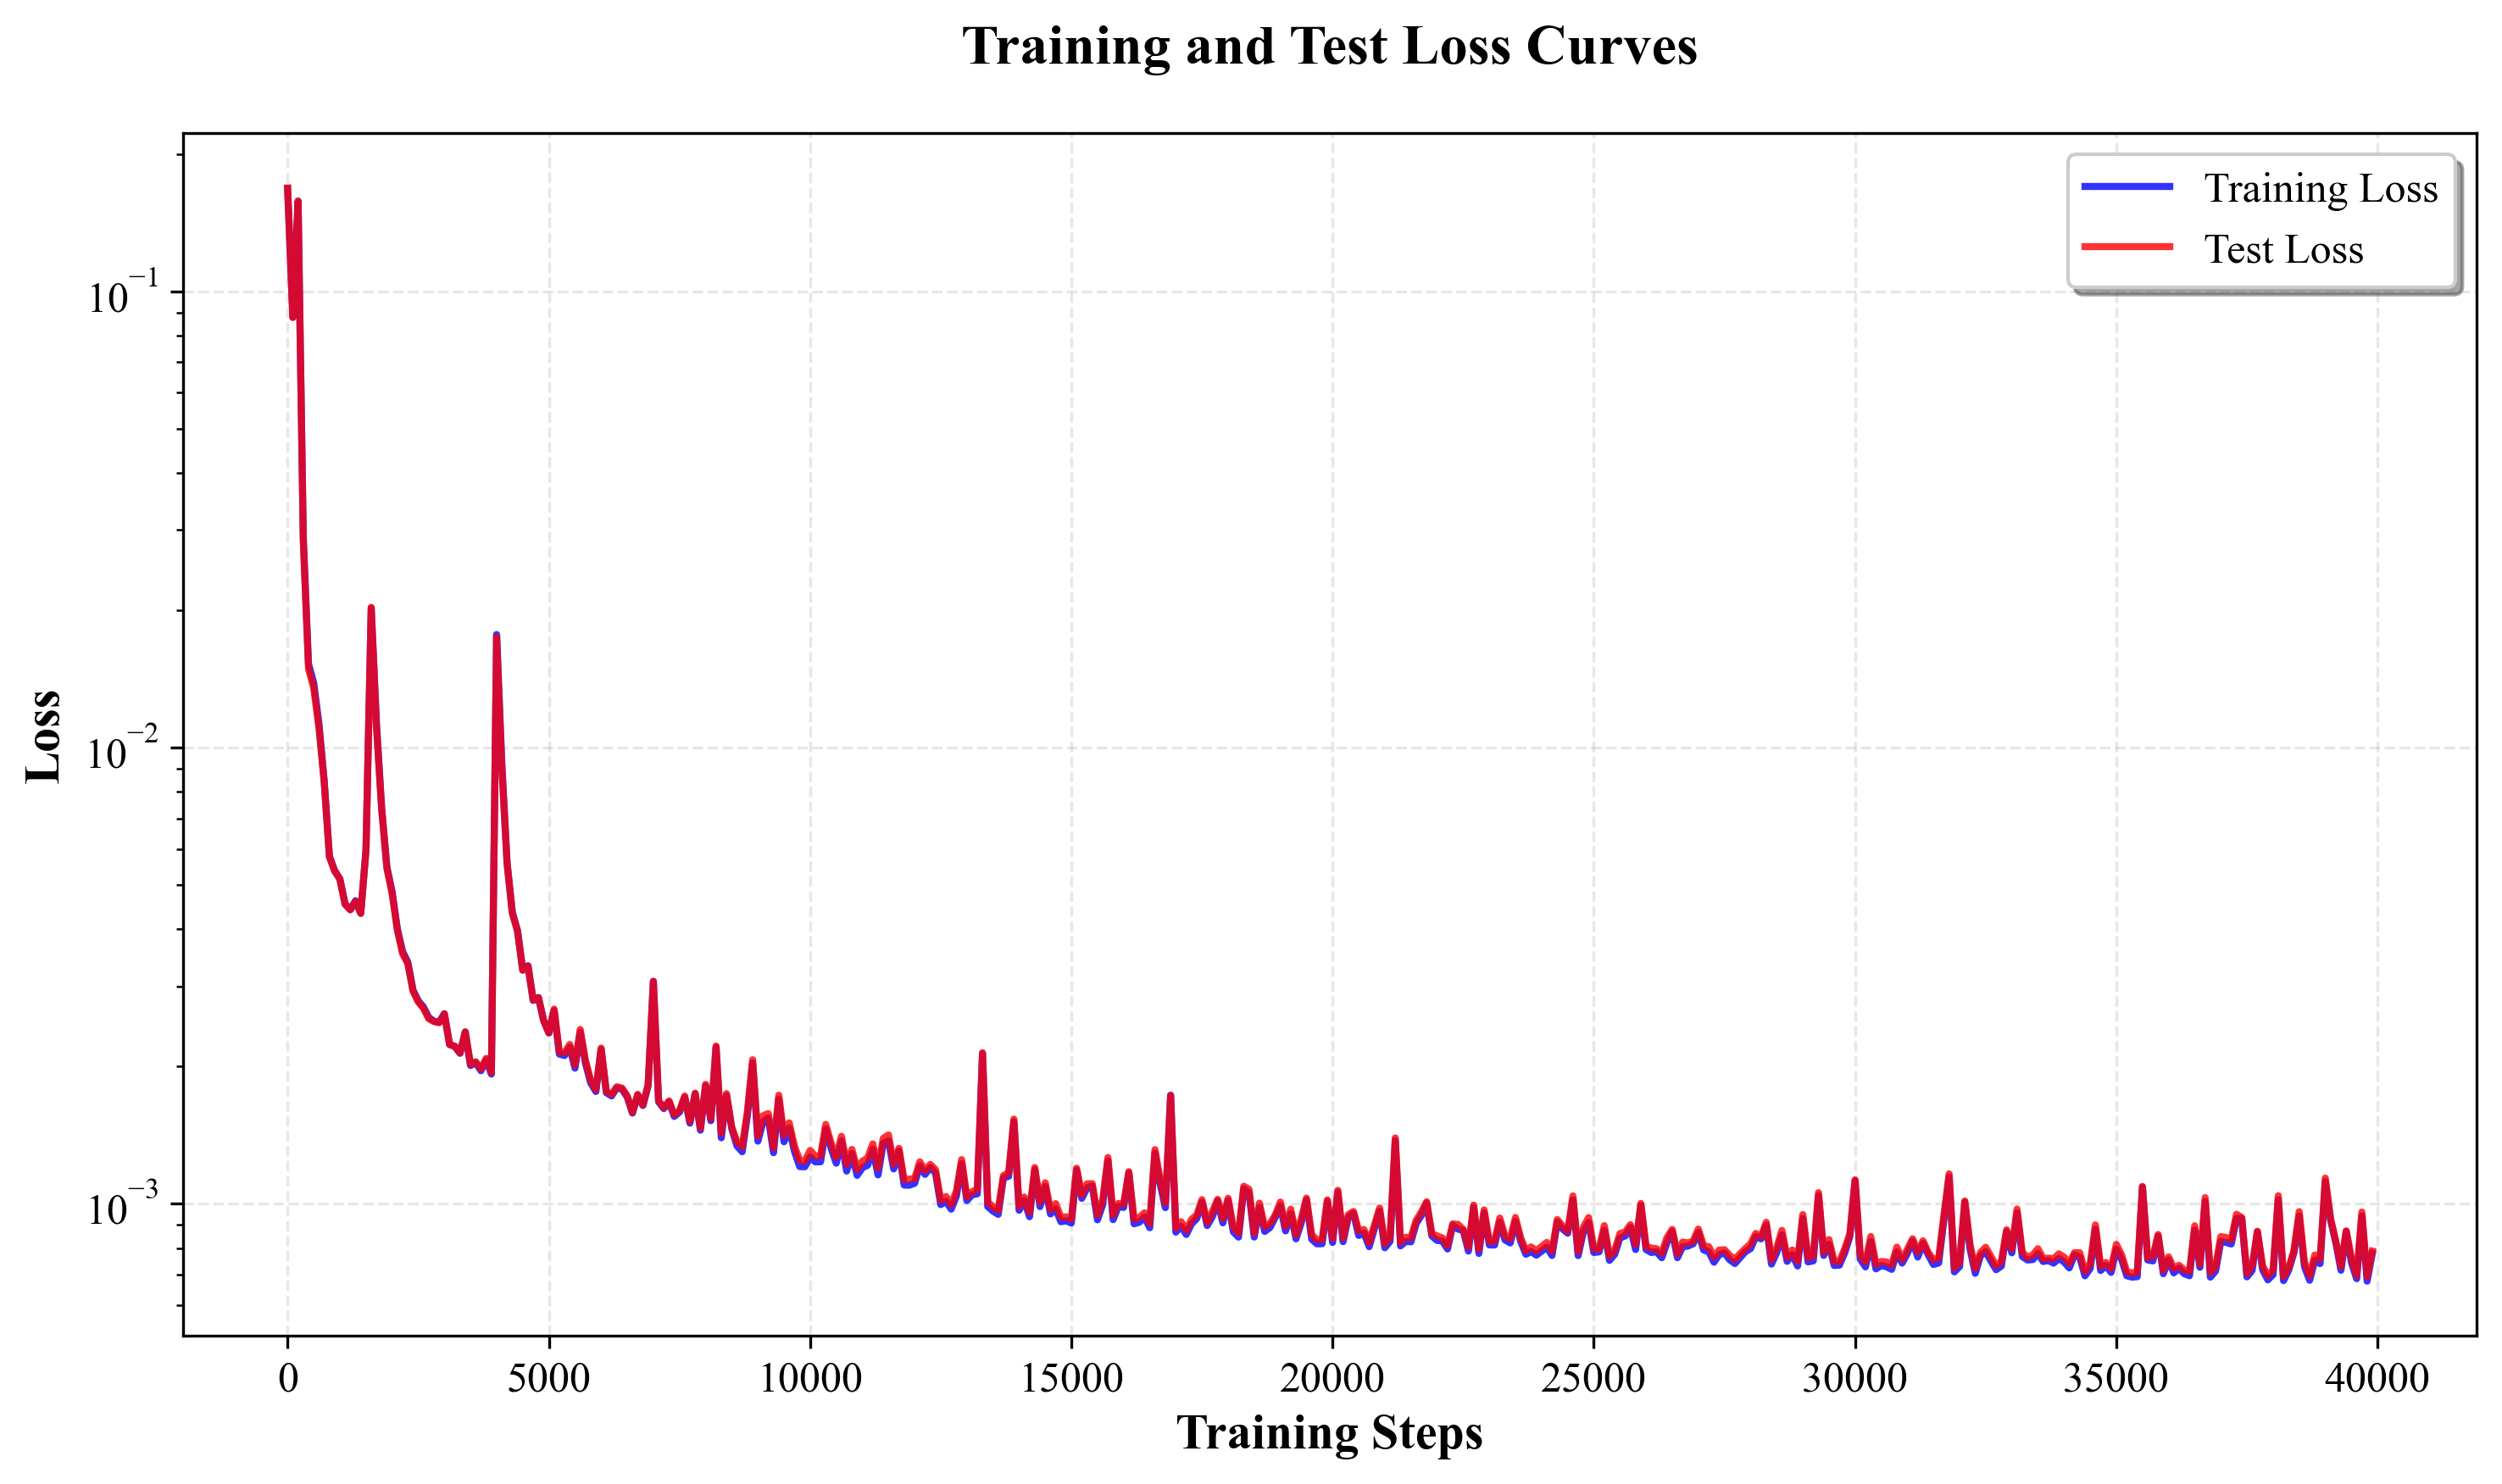

损失曲线图已保存至 ./models1008/checkpoints/


<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 设置论文级别的图形样式
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("losshistory.loss_train=",losshistory.loss_train)
print("type(losshistory.steps)=",type(losshistory.steps))

# 创建更规范的损失曲线图
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)

# 绘制训练和测试损失
steps = np.array(losshistory.steps)
train_loss = np.array(losshistory.loss_train)
test_loss = np.array(losshistory.loss_test)

# 可以选择显示全部数据或者前400步
max_steps = min(400, len(steps)) if len(steps) > 400 else len(steps)
steps_plot = steps[:max_steps]
train_loss_plot = train_loss[:max_steps]
test_loss_plot = test_loss[:max_steps]

ax.plot(steps_plot, train_loss_plot, 'b-', label='Training Loss', alpha=0.8)
ax.plot(steps_plot, test_loss_plot, 'r-', label='Test Loss', alpha=0.8)

# 设置坐标轴
ax.set_xlabel('Training Steps', fontweight='bold')
ax.set_ylabel('Loss', fontweight='bold')
ax.set_title('Training and Test Loss Curves', fontweight='bold', pad=20)

# 设置对数坐标（如果损失值变化范围很大）
ax.set_yscale('log')

# 添加网格
ax.grid(True, alpha=0.3, linestyle='--')

# 设置图例
ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)

# 自动调整布局
plt.tight_layout()

# 显示图形
plt.show()

# 保存高质量图片
plt.savefig(os.path.join(model_save_path, "training_loss_curve.png"), 
           dpi=300, bbox_inches='tight', format='png')
plt.savefig(os.path.join(model_save_path, "training_loss_curve.pdf"), 
           bbox_inches='tight', format='pdf')

print(f"损失曲线图已保存至 {model_save_path}")

In [17]:
# 更详细的损失分析和可视化
def plot_comprehensive_loss_analysis(losshistory, save_path=None):
    """
    绘制comprehensive损失分析图，包括：
    1. 完整的训练/测试损失曲线
    2. 损失的移动平均
    3. 损失收敛分析
    """
    
    # 设置图形参数
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'lines.linewidth': 2,
        'axes.grid': True,
        'grid.alpha': 0.3
    })
    
    steps = np.array(losshistory.steps)
    train_loss = np.array(losshistory.loss_train).squeeze
    test_loss = np.array(losshistory.loss_test).squeeze
    
    # 创建子图
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10), dpi=300)
    
    # 1. 完整损失曲线（线性坐标）
    ax1.plot(steps, train_loss, 'b-', label='Training Loss', alpha=0.8)
    ax1.plot(steps, test_loss, 'r-', label='Test Loss', alpha=0.8)
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss (Linear Scale)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 对数坐标损失曲线
    ax2.plot(steps, train_loss, 'b-', label='Training Loss', alpha=0.8)
    ax2.plot(steps, test_loss, 'r-', label='Test Loss', alpha=0.8)
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Loss (Log Scale)')
    ax2.set_title('Training and Test Loss (Log Scale)')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. 移动平均损失（平滑曲线）
    if len(train_loss) > 50:
        window_size = min(50, len(train_loss) // 10)
        train_smooth = np.convolve(train_loss, np.ones(window_size)/window_size, mode='valid')
        test_smooth = np.convolve(test_loss, np.ones(window_size)/window_size, mode='valid')
        steps_smooth = steps[window_size-1:]
        
        ax3.plot(steps_smooth, train_smooth, 'b-', label='Training Loss (Smoothed)', alpha=0.8)
        ax3.plot(steps_smooth, test_smooth, 'r-', label='Test Loss (Smoothed)', alpha=0.8)
    else:
        ax3.plot(steps, train_loss, 'b-', label='Training Loss', alpha=0.8)
        ax3.plot(steps, test_loss, 'r-', label='Test Loss', alpha=0.8)
    
    ax3.set_xlabel('Training Steps')
    ax3.set_ylabel('Loss')
    ax3.set_title('Smoothed Loss Curves')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. 损失比值分析（过拟合检测）
    loss_ratio = test_loss / train_loss
    ax4.plot(steps, loss_ratio, 'g-', label='Test/Train Loss Ratio', alpha=0.8)
    ax4.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Ratio = 1.0')
    ax4.set_xlabel('Training Steps')
    ax4.set_ylabel('Loss Ratio')
    ax4.set_title('Overfitting Analysis (Test/Train Ratio)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 调整布局
    plt.tight_layout()
    plt.show()
    
    # 保存图片
    if save_path:
        fig.savefig(os.path.join(save_path, "comprehensive_loss_analysis.png"), 
                   dpi=300, bbox_inches='tight', format='png')
        fig.savefig(os.path.join(save_path, "comprehensive_loss_analysis.pdf"), 
                   bbox_inches='tight', format='pdf')
        print(f"综合损失分析图已保存至 {save_path}")
    
    return fig

# 调用函数绘制综合分析图
# plot_comprehensive_loss_analysis(losshistory, model_save_path)

In [18]:
import pickle

# 保存 losshistory 和 train_state 到指定路径
losshistory_file = os.path.join(model_save_path, "losshistory.pkl")
train_state_file = os.path.join(model_save_path, "train_state.pkl")

with open(losshistory_file, "wb") as f:
    pickle.dump(losshistory, f)

with open(train_state_file, "wb") as f:
    pickle.dump(train_state, f)

print(f"losshistory 保存至 {losshistory_file}")
print(f"train_state 保存至 {train_state_file}")


losshistory 保存至 ./models1008/checkpoints/losshistory.pkl
train_state 保存至 ./models1008/checkpoints/train_state.pkl


In [19]:
# 从指定路径加载 losshistory 和 train_state
with open(os.path.join(model_save_path, "losshistory.pkl"), "rb") as f:
    losshistory_loaded = pickle.load(f)

with open(os.path.join(model_save_path, "train_state.pkl"), "rb") as f:
    train_state_loaded = pickle.load(f)

print("losshistory 和 train_state 已从指定路径加载。")



losshistory 和 train_state 已从指定路径加载。


In [ ]:
'''  
#import deepxde as dde
#dde.saveplot(losshistory, train_state, issave=True, isplot=True)
def run(m, net, lr, epochs):
    d = np.load("train.npz")
    X_train, y_train = (d["X_train0"], d["X_train1"]), d["y_train"]
    d = np.load("test.npz")
    X_test, y_test = (d["X_test0"], d["X_test1"]), d["y_test"]

    X_test_trim = trim_to_65535(X_test)[0]
    y_test_trim = trim_to_65535(y_test)[0]
    data = dde.data.OpDataSet(
        X_train=X_train, y_train=y_train, X_test=X_test_trim, y_test=y_test_trim
    )

    model = dde.Model(data, net)
    model.compile("adam", lr=lr, metrics=[mean_squared_error_outlier])
    checker = dde.callbacks.ModelCheckpoint(
        "model/model.ckpt", save_better_only=True, period=1000
    )
    losshistory, train_state = model.train(epochs=epochs, callbacks=[checker])
    dde.saveplot(losshistory, train_state, issave=False, isplot=True)

    model.restore("model/model.ckpt-" + str(train_state.best_step), verbose=1)
    safe_test(model, data, X_test, y_test)

    for i in range(10):
        d = np.load("example{}.npz".format(i))
        X_test, y_test = (d["X_test0"], d["X_test1"]), d["y_test"]
        safe_test(model, data, X_test, y_test, fname="example{}.dat".format(i))

'''

'  \n#import deepxde as dde\n#dde.saveplot(losshistory, train_state, issave=True, isplot=True)\ndef run(m, net, lr, epochs):\n    d = np.load("train.npz")\n    X_train, y_train = (d["X_train0"], d["X_train1"]), d["y_train"]\n    d = np.load("test.npz")\n    X_test, y_test = (d["X_test0"], d["X_test1"]), d["y_test"]\n\n    X_test_trim = trim_to_65535(X_test)[0]\n    y_test_trim = trim_to_65535(y_test)[0]\n    data = dde.data.OpDataSet(\n        X_train=X_train, y_train=y_train, X_test=X_test_trim, y_test=y_test_trim\n    )\n\n    model = dde.Model(data, net)\n    model.compile("adam", lr=lr, metrics=[mean_squared_error_outlier])\n    checker = dde.callbacks.ModelCheckpoint(\n        "model/model.ckpt", save_better_only=True, period=1000\n    )\n    losshistory, train_state = model.train(epochs=epochs, callbacks=[checker])\n    dde.saveplot(losshistory, train_state, issave=False, isplot=True)\n\n    model.restore("model/model.ckpt-" + str(train_state.best_step), verbose=1)\n    safe_test

# 1. 模型训练
losshistory, train_state = model.train(iterations=10000)

# 2. 保存模型
model.save("models/mionet_model.ckpt", verbose=1)

# 3. 恢复模型
model.restore("models/mionet_model.ckpt", device="cpu", verbose=1)

# 4. 模型预测
x_test = np.random.rand(100, 2)  # 示例测试数据
y_pred = model.predict(x_test)

# 5. 自定义后处理预测
def scale_output(output):
    return output * 10

y_scaled = model.predict(x_test, operator=scale_output)

# 6. 添加预测回调
def log_prediction(y_pred):
    print("Predicted values:", y_pred[:5])  # 打印前5个预测结果

y_with_callback = model.predict(x_test, callbacks=[log_prediction])
